# Bayesian Multilevel Modeling: Who will win the 2018 Premier League? 

## Introduction

As a fan of soccer and an aspiring engineering student I always thought it would be interesting to work on a data science project involving the sport I love. The goal of this project was to model the current form of teams in the 2018/2019 premier league and use that model to predict the final standings for the season. This is my first forey into Bayesian Modeling with PyMC3 and has been influenced by the following resources: 

**Original Paper:** http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.182.8659&rep=rep1&type=pdf 

**Source 1:** http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/

**How I learnt PyMC3:** Bayesian Methods for Hackers 

**Data Source:** http://www.football-data.co.uk/data.php 

## Development Plan 

-  Prepare Dataset: 
    -  Load Betting Data
    -  Clean 
    -  Add 2019 fixtures 

-  Build Model: 
    -  Creat Shared Predictors, Encode Home and Away Teams as ints 
    -  Model Attack and Defence Rates
    -  Model Home and away shots 
    -  Model Home Advantage 
    -  Train using 2018 game data
    
-  Simulate remainder of the Season

## ToDo / In development

-  Add European Fixture Indicator to Dataset (Simple bool, need to find good schedule data)
-  Model Fatigue (Reserch needed, might be a function of total number of games playes) 
-  Indicator for first team transfers (Model using some discrete uniform distribution for each team) 


## Libraries:

In [45]:
# import libraries 
import pymc3 as pm3
import theano
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
# for experimentation 
np.random.seed(10)
# Inline plotting in jupyter
%matplotlib inline

## Define Functions for Analysis: 

In [46]:
def get_standing(fixture_list, ppc, simulation):

    fixture_list.loc[~fixture_list.played, "FTAG"] = ppc["away_goals"][simulation]
    fixture_list.loc[~fixture_list.played, "FTHG"] = ppc["home_goals"][simulation]

    fixture_list["homepoints"] = (3 * (fixture_list.FTHG > fixture_list.FTAG)).fillna(0) + (1 * (fixture_list.FTHG == fixture_list.FTAG)).fillna(0)
    fixture_list["awaypoints"] = (3 * (fixture_list.FTAG > fixture_list.FTHG)).fillna(0) + (1 * (fixture_list.FTHG == fixture_list.FTAG)).fillna(0)

    standing = fixture_list.groupby("HomeTeam").homepoints.sum().to_frame().join(
        fixture_list.groupby("AwayTeam").awaypoints.sum()
    ).join(
        fixture_list.groupby("HomeTeam").FTHG.sum()
    ).join(
        fixture_list.groupby("AwayTeam").FTAG.sum()
    ).join(
        fixture_list.groupby("HomeTeam").FTAG.sum().rename("homegoals_against")
    ).join(
        fixture_list.groupby("AwayTeam").FTHG.sum().rename("awaygoals_against")
    )

    standing["points"] = standing.homepoints + standing.awaypoints
    standing["goals"] = standing.FTHG + standing.FTAG
    standing["goals_against"] = standing.homegoals_against + standing.awaygoals_against
    

    return standing.sort_values(["points", "goals"], ascending = False).assign( rank = list(range(1, len(standing) + 1))).reset_index()

def plot_probabilities(sims, simulation_2019):
    simulations = pd.concat([get_standing(total_fixtures, simulation_2019, i) for i in range(sims)])
    rankings_agg = simulations.groupby("HomeTeam")['rank'].value_counts(normalize = True).unstack(1).fillna(0)
    rankings_agg = rankings_agg.assign( expected = rankings_agg @ np.arange(n_teams + 1, 1, -1)).sort_values( "expected", ascending = False).drop("expected", axis = "columns")
    plt.figure(figsize = (15, 15))
    sns.heatmap(rankings_agg, annot=True, fmt=".0%", cbar=False, cmap="ocean")
    plt.ylabel("")

## Dataset Prep:

In [47]:
# Get Played Fixtures Data 
data = pd.read_csv("soccer_data.csv")
# Get future games 
games_2019 = pd.read_csv("next_fixtures.csv")

In [48]:
data.head(5) # Check if data is loaded correctly 

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


In [49]:
# Data Cleaning: Remove irrelevant columns
data = data.drop(["Div","Referee", "FTR", "HTR"], axis = 1 )
# Data from a betting site, drop all non sporting columns 
data = data.iloc[:, 0:19]

In [50]:
# Check is cleaning is correct 
data.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,10/08/2018,Man United,Leicester,2,1,1,0,8,13,6,4,11,8,2,5,2,1,0,0
1,11/08/2018,Bournemouth,Cardiff,2,0,1,0,12,10,4,1,11,9,7,4,1,1,0,0
2,11/08/2018,Fulham,Crystal Palace,0,2,0,1,15,10,6,9,9,11,5,5,1,2,0,0
3,11/08/2018,Huddersfield,Chelsea,0,3,0,2,6,13,1,4,9,8,2,5,2,1,0,0
4,11/08/2018,Newcastle,Tottenham,1,2,1,2,15,15,2,5,11,12,3,5,2,2,0,0


In [51]:
# Clean 2019 games data 
games_2019 = games_2019.drop("Result",axis = 1)
games_2019.head(5)

,Date,HomeTeam,AwayTeam
0,12/01/2019 12:30,West Ham,Arsenal
1,12/01/2019 15:00,Brighton,Liverpool
2,12/01/2019 15:00,Burnley,Fulham
3,12/01/2019 15:00,Cardiff,Huddersfield
4,12/01/2019 15:00,Crystal Palace,Watford


In [52]:
# Merge the two Data frames 
total_fixtures = pd.concat([data,games_2019], axis=0)
total_fixtures = total_fixtures.reset_index()
total_fixtures = total_fixtures.drop("index", axis = 1)
# Change to date to python date time format 
total_fixtures['Date'] =  pd.to_datetime(total_fixtures['Date'])

c:\users\ncalen\myenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [53]:
# Add the played game column 
total_fixtures['played'] = True # True if played, else False 
# Correctly Assign game status
for game in range(0,len(total_fixtures)):
    if np.isnan(total_fixtures.loc[game,'AC']):
        total_fixtures.loc[game,'played'] = False

In [54]:
# Check if correctly merged 
total_fixtures.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,FTAG,FTHG,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,played
0,5.0,8.0,0.0,13.0,4.0,1.0,Leicester,2018-10-08,1.0,2.0,2.0,11.0,0.0,8.0,6.0,0.0,1.0,2.0,Man United,True
1,4.0,9.0,0.0,10.0,1.0,1.0,Cardiff,2018-11-08,0.0,2.0,7.0,11.0,0.0,12.0,4.0,0.0,1.0,1.0,Bournemouth,True
2,5.0,11.0,0.0,10.0,9.0,2.0,Crystal Palace,2018-11-08,2.0,0.0,5.0,9.0,0.0,15.0,6.0,1.0,0.0,1.0,Fulham,True
3,5.0,8.0,0.0,13.0,4.0,1.0,Chelsea,2018-11-08,3.0,0.0,2.0,9.0,0.0,6.0,1.0,2.0,0.0,2.0,Huddersfield,True
4,5.0,12.0,0.0,15.0,5.0,2.0,Tottenham,2018-11-08,2.0,1.0,3.0,11.0,0.0,15.0,2.0,2.0,1.0,2.0,Newcastle,True


In [55]:
total_fixtures.tail()

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,FTAG,FTHG,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,played
375,NaN,NaN,NaN,NaN,NaN,NaN,Wolves,2019-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liverpool,False
376,NaN,NaN,NaN,NaN,NaN,NaN,Cardiff,2019-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Man Utd,False
377,NaN,NaN,NaN,NaN,NaN,NaN,Huddersfield,2019-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Southampton,False
378,NaN,NaN,NaN,NaN,NaN,NaN,Everton,2019-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spurs,False
379,NaN,NaN,NaN,NaN,NaN,NaN,West Ham,2019-12-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Watford,False


Nothing wrong with this dataframe. Features are now just in alphabetical order. 

In [56]:
# Check name convensions for each team are the same 
total_fixtures.HomeTeam.unique()

array(['Man United', 'Bournemouth', 'Fulham', 'Huddersfield', 'Newcastle',
       'Watford', 'Wolves', 'Arsenal', 'Liverpool', 'Southampton',
       'Cardiff', 'Chelsea', 'Everton', 'Leicester', 'Tottenham',
       'West Ham', 'Brighton', 'Burnley', 'Man City', 'Crystal Palace',
       'Spurs', 'Man Utd'], dtype=object)

In [57]:
# Looks like we have some mismatched team names from the data sets. Change so that they are the same.  
for game in range(0,len(total_fixtures)):
    if total_fixtures.loc[game,'HomeTeam'] == 'Man Utd':
        total_fixtures.loc[game,'HomeTeam'] = 'Man United'
    if total_fixtures.loc[game,'AwayTeam'] == 'Man Utd':
        total_fixtures.loc[game,'AwayTeam'] = 'Man United'
    
    if total_fixtures.loc[game,'HomeTeam'] == 'Spurs':
        total_fixtures.loc[game,'HomeTeam'] = 'Tottenham'
    if total_fixtures.loc[game,'AwayTeam'] == 'Spurs':
        total_fixtures.loc[game,'AwayTeam'] = 'Tottenham'
        
# Home and Away Teams must be the catagory dtype: 
total_fixtures['HomeTeam'] = total_fixtures['HomeTeam'].astype('category')
total_fixtures['AwayTeam'] = total_fixtures['AwayTeam'].astype('category')

For clarity, lets list the poorly named features in the dataset and describe their true meaning: 

-  AC = Away Team Corners
-  AF = Away Team Fouls
-  AR = Away Team Red Cards 
-  AS = Away Team Shots 
-  AST = Away Team Shots on Target 
-  AY = Away Team Yellow Cards  
-  FTAG = Full Time away goals 
-  FTHG = Full Time Home Team Goals 
-  HC = Home Team Corners 
-  HF = Home Team Fouls Commited 
-  HR = Home Team Red Cards 
-  HS = Home Team Shots
-  HST = Home Team Shots on Target
-  HTAG = Half Time Away Goals 
-  HTHG = Half Time Home Goals
-  HY = Home Team Yellow Cards

And finally the Finalized Data Set info: 

In [58]:
total_fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 20 columns):
AC          210 non-null float64
AF          210 non-null float64
AR          210 non-null float64
AS          210 non-null float64
AST         210 non-null float64
AY          210 non-null float64
AwayTeam    380 non-null category
Date        380 non-null datetime64[ns]
FTAG        210 non-null float64
FTHG        210 non-null float64
HC          210 non-null float64
HF          210 non-null float64
HR          210 non-null float64
HS          210 non-null float64
HST         210 non-null float64
HTAG        210 non-null float64
HTHG        210 non-null float64
HY          210 non-null float64
HomeTeam    380 non-null category
played      380 non-null bool
dtypes: bool(1), category(2), datetime64[ns](1), float64(16)
memory usage: 53.2 KB


In [59]:
total_fixtures.dtypes

AC                 float64
AF                 float64
AR                 float64
AS                 float64
AST                float64
AY                 float64
AwayTeam          category
Date        datetime64[ns]
FTAG               float64
FTHG               float64
HC                 float64
HF                 float64
HR                 float64
HS                 float64
HST                float64
HTAG               float64
HTHG               float64
HY                 float64
HomeTeam          category
played                bool
dtype: object

Looks good! Lets start the model building. 

## Modeling: 

In [60]:
n_teams = len(total_fixtures.HomeTeam.unique()) # Number of teams in the league 
print("Number of Teams: ", n_teams) # Confirm right number of teams 
# Seperate Dataset into matches played and not played
played = total_fixtures[total_fixtures.played]
not_played = total_fixtures[~total_fixtures.played]
# create shared predictors. We can change these easily later for matches we want to predict!
hometeam = theano.shared(played.HomeTeam.cat.codes.astype('int8').values)
awayteam = theano.shared(played.AwayTeam.cat.codes.astype('int8').values)

Number of Teams:  20


## Modeling Attack and Defensive Rates

In [61]:
# See paper by Biao et. al. for all model mathematics 
with pm3.Model() as model:
    # For Team Attack Rate 
    # Set Hyperpriors 
    param_attack = pm3.Normal('param_attack', 0, 1) # var name, mean, std 
    param_attack_sd = pm3.Gamma('param_attack_sd', 2, 2)
    param_attack_nc = pm3.Normal('param_attack_nc', 0, 1, shape = n_teams) # For each team 
    # Create the Deterministic Function Dependent on the other params 
    attack_rate = pm3.Deterministic('attack_rate', param_attack + param_attack_nc * param_attack_sd) # name, parent var
    # Note on parent var: parameter that influences the other parameters. Initial guess does not matter. 
    # For Team Defense Rate 
    param_defense_nc = pm3.Normal('param_defense_nc', 0, 1, shape = n_teams) # For each team 
    param_defense_sd = pm3.Gamma('param_defense_sd', 2, 2) 
    defense_rate = pm3.Deterministic('defense_rate', param_defense_nc * param_defense_sd)

## Modeling Shots on Target: 

In [62]:
# Prepare a distribution that will model a shots on target rate 
with model: 
    # Home Team 
    param_shots_home_hyper_sd = pm3.Gamma('param_shots_home_hyper_sd', 1, 1)
    home_shots_nc = pm3.Normal('home_shots_nc', 2, 1, shape = n_teams)
    home_shots = pm3.Deterministic('home_shots', home_shots_nc * param_shots_home_hyper_sd )
    # Away Team 
    param_shots_away_hyper_sd = pm3.Gamma('param_shots_away_hyper_sd', 1, 1)
    away_shots_nc = pm3.Normal('away_shots_nc', 2, 1, shape = n_teams)
    away_shots = pm3.Deterministic('away_shots', away_shots_nc * param_shots_away_hyper_sd) 

## Modeling the Home Advantage 

In [63]:
# Accroding to the paper teams typically have a home advantage. Roar of the crowd, e.t.c. 
with model:
    # Attack Params
    param_attack_hyper_sd = pm3.Gamma('param_attack_hyper_sd', 2, 2)
    param_attack_home_hyper = pm3.Normal('param_attack_home_hyper', 0, 1)
    parma_attack_home_nc = pm3.Normal('parma_attack_home_nc', 0, 1, shape = n_teams)    
    home_attack_advantage = pm3.Deterministic('home_attack_advantage', param_attack_home_hyper + 
                                             parma_attack_home_nc * param_attack_hyper_sd)
    # Defensive Params 
    home_defense_hyper = pm3.Normal('home_defense_hyper', 0, 1)
    home_defense_hyper_sd = pm3.Gamma("home_defense_hyper_sd", 2, 2)
    home_defense_nc = pm3.Normal('home_defense_nc', 0, 1, shape = n_teams)
    home_defense_advantage = pm3.Deterministic('home_defense_advantage', home_defense_hyper + home_defense_nc * home_defense_hyper_sd)

## Putting it All Together:

In [64]:
with model:
    # Prepare the parent vars for the exponential link of the Poisson Distribution - Goals scored distribution 
    home_diff = attack_rate[hometeam] - defense_rate[awayteam] + home_attack_advantage[hometeam] + home_shots[hometeam]
    away_diff = attack_rate[awayteam] - defense_rate[hometeam] - home_defense_advantage[hometeam] + away_shots[awayteam]

In [65]:
with model:
    # observed parameter is our real life observations. Used to update our prior beleifs (those distributions I created)
    # in Bayesian Fashion 
    home_goals = pm3.Poisson('home_goals', pm3.math.exp(home_diff), observed = played.FTHG.values) # Link with home_diff var
    away_goals = pm3.Poisson('away_goals', pm3.math.exp(away_diff), observed = played.FTAG.values) # link with away_diff var

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_defense_nc, home_defense_hyper_sd, home_defense_hyper, parma_attack_home_nc, param_attack_home_hyper, param_attack_hyper_sd, away_shots_nc, param_shots_away_hyper_sd, home_shots_nc, param_shots_home_hyper_sd, param_defense_sd, param_defense_nc, param_attack_nc, param_attack_sd, param_attack]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


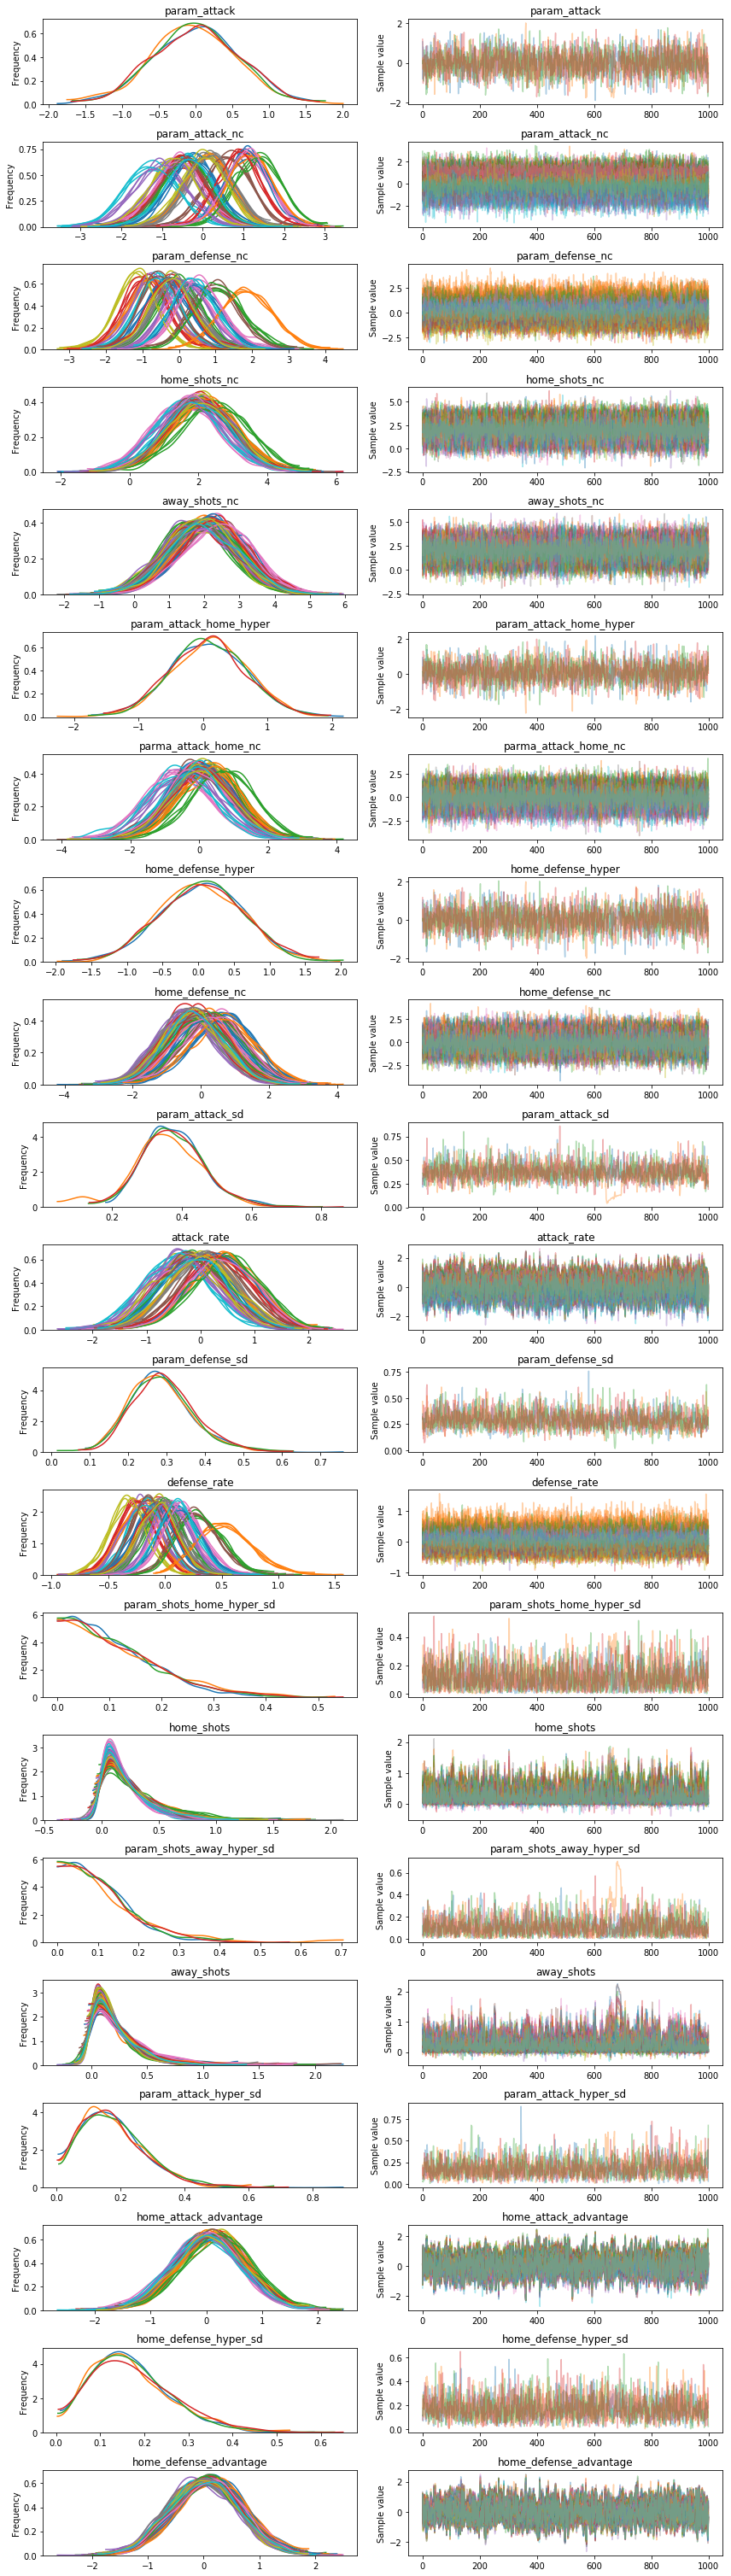

In [68]:
with model:
    trained_model = pm3.sample(1000, tune=1000, cores=4, progressbar = False) # Run Model. Same as training the model. 
pm3.traceplot(trained_model);

In [69]:
# Switching. Now make predictions by sampling the posteriors.  
hometeam.set_value(not_played.HomeTeam.cat.codes.astype('int8').values)
awayteam.set_value(not_played.AwayTeam.cat.codes.astype('int8').values)

with model: # Simulate games over 1000 simulated seasons 
    simulation_2019 = pm3.sample_ppc(trained_model, samples = 1000)

c:\users\ncalen\myenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.51it/s]

In [70]:
get_standing(total_fixtures, simulation_2019, 996) # Show an example standing i.e. standing according to simulation 996

,HomeTeam,homepoints,awaypoints,FTHG,FTAG,homegoals_against,awaygoals_against,points,goals,goals_against,rank
0,Liverpool,53,43,50.0,41.0,7.0,11.0,96,91.0,18.0,1
1,Man City,49,28,64.0,25.0,21.0,18.0,77,89.0,39.0,2
2,Tottenham,38,38,41.0,43.0,17.0,23.0,76,84.0,40.0,3
3,Chelsea,42,34,40.0,33.0,11.0,23.0,76,73.0,34.0,4
4,Arsenal,50,24,59.0,39.0,19.0,38.0,74,98.0,57.0,5
5,Everton,34,33,35.0,41.0,29.0,20.0,67,76.0,49.0,6
6,Man United,41,25,43.0,32.0,23.0,35.0,66,75.0,58.0,7
7,Watford,34,23,31.0,24.0,24.0,25.0,57,55.0,49.0,8
8,Wolves,31,23,23.0,19.0,18.0,25.0,54,42.0,43.0,9
9,Bournemouth,30,17,27.0,19.0,27.0,40.0,47,46.0,67.0,10


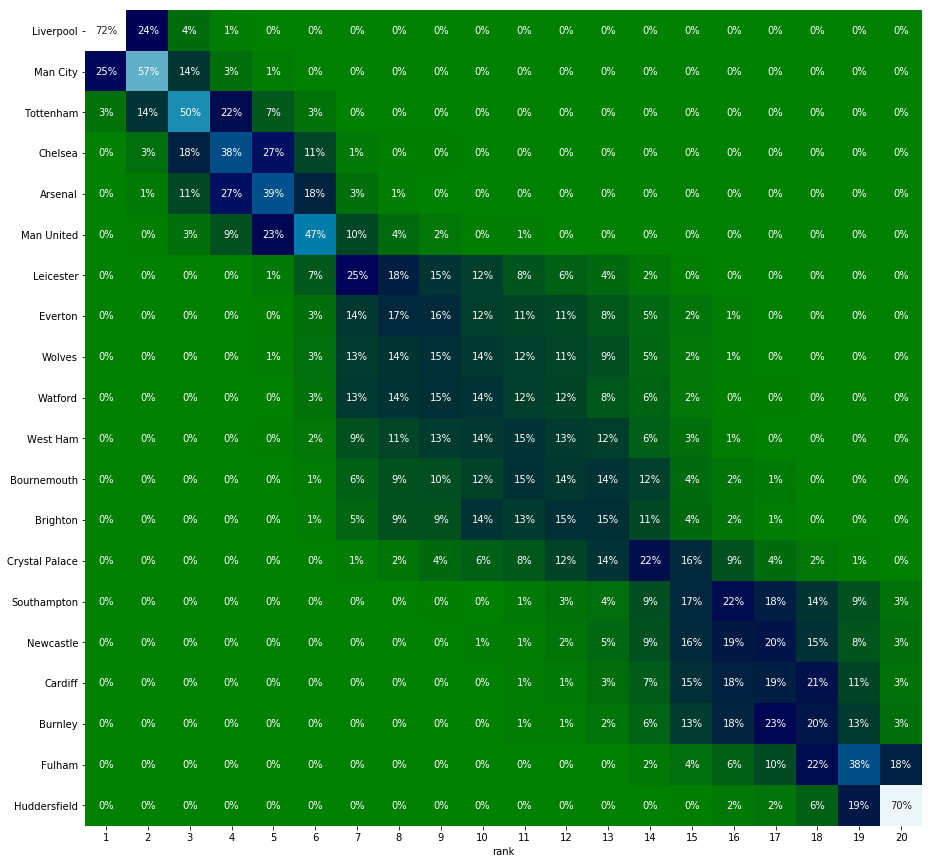

In [73]:
# Plot the positon probabilities after n experiments: 
plot_probabilities(1000, simulation_2019)

# END